In [1]:
pip install pyodbc sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sqlalchemy import create_engine

server = "localhost"       
database = "QAECECRM_DA_MayFT1-2025-8-12-18-9"   
driver = "ODBC Driver 17 for SQL Server"  

connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver}"
engine = create_engine(connection_string)

In [3]:
# Exploring the Data
import pandas as pd

query1 = "SELECT * from dbo.BlueCard;"  
query2 = "Select * from dbo.Lead"
query3 = "Select * from dbo.PayrollPayment"
query4 = "Select * from dbo.BlueCardArtist"
query5 = "Select * from dbo.AgentPayrollLog"
bluecard = pd.read_sql(query1, engine)
agent_payroll= pd.read_sql(query5, engine)


bluecard.info()
agent_payroll.info()

# Quick look at missing values
print(bluecard.isnull().sum())
print(agent_payroll.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200008 entries, 0 to 200007
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BlueCardId              200008 non-null  int64         
 1   AgentId                 200008 non-null  int64         
 2   PresenterId             73461 non-null   float64       
 3   AccountName             192112 non-null  object        
 4   OrganizationName        67513 non-null   object        
 5   EventTypeId             198696 non-null  float64       
 6   LeadId                  28398 non-null   float64       
 7   VenueId                 19107 non-null   float64       
 8   VenueName               67475 non-null   object        
 9   VenuePhysicalAddress1   67102 non-null   object        
 10  VenuePhysicalAddress2   67102 non-null   object        
 11  VenuePhysicalCity       67475 non-null   object        
 12  VenuePhysicalStateId    66170 

In [5]:

bluecard_summary = bluecard.groupby('AgentId').agg({
    'BlueCardId': 'count',                    
    'LeadId': lambda x: x.notnull().sum(),    
}).reset_index()

bluecard_summary.rename(columns={
    'BlueCardId': 'TotalBlueCards',
    'LeadId': 'TotalLeads'
}, inplace=True)

agent_summary = agent_payroll.groupby('AgentId').agg({
    'GrossAmount': 'sum',
    'NetAmount': 'sum',
    'CommissionRate': 'mean'
}).reset_index()

agent_summary.rename(columns={
    'GrossAmount': 'TotalGross',
    'NetAmount': 'TotalNet',
    'CommissionRate': 'AvgCommission'
}, inplace=True)

merged_df = pd.merge(bluecard_summary, agent_summary, on='AgentId', how='inner')
merged_df['Revenue'] = merged_df['TotalNet']
merged_df['ProfitMargin'] = merged_df['TotalNet'] / merged_df['TotalGross']
merged_df['RevenuePerEvent'] = merged_df['Revenue'] / merged_df['TotalBlueCards']

# Clean and replace problematic values
merged_df.replace([np.inf, -np.inf], 0, inplace=True)
merged_df.fillna(0, inplace=True)

Data shape: (174, 9)
   AgentId  TotalBlueCards  TotalLeads  TotalGross   TotalNet  AvgCommission  \
0        3              25           5    20950.00   10800.00       2.857143   
1      104             637         298   295931.77  106384.83      29.399067   
2      106             548          19   816381.01  486667.01      31.923077   
3      107             364           0    18650.60   19163.60      72.906404   
4      110             382           0  1184904.92  475594.98      35.986849   

     Revenue  ProfitMargin  RevenuePerEvent  
0   10800.00      0.515513       432.000000  
1  106384.83      0.359491       167.009152  
2  486667.01      0.596127       888.078485  
3   19163.60      1.027506        52.647253  
4  475594.98      0.401378      1245.013037  

Correlation Matrix:
                 TotalLeads  TotalBlueCards  TotalGross  TotalNet  \
TotalLeads         1.000000        0.651155    0.463508  0.524227   
TotalBlueCards     0.651155        1.000000    0.780419  0.8008

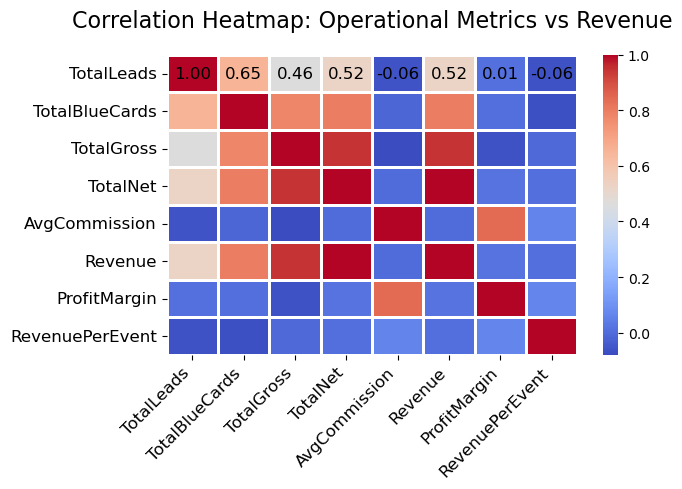

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Data shape:", merged_df.shape)
print(merged_df.head())

metrics = ['TotalLeads', 'TotalBlueCards', 'TotalGross', 'TotalNet', 
           'AvgCommission', 'Revenue', 'ProfitMargin', 'RevenuePerEvent']

numeric_df = merged_df[[col for col in metrics if col in merged_df.columns]]

numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]
numeric_df = numeric_df[(numeric_df.T != 0).any()]

corr_matrix = numeric_df.corr(method='pearson')
print("\nCorrelation Matrix:")
print(corr_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

corr_plot = corr_matrix.copy()

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    corr_plot,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=False,
    linewidths=1,
    linecolor='white',
    cbar=True,
    annot_kws={"size": 12, "color": "black"}
)

ax.set_title("Correlation Heatmap: Operational Metrics vs Revenue", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

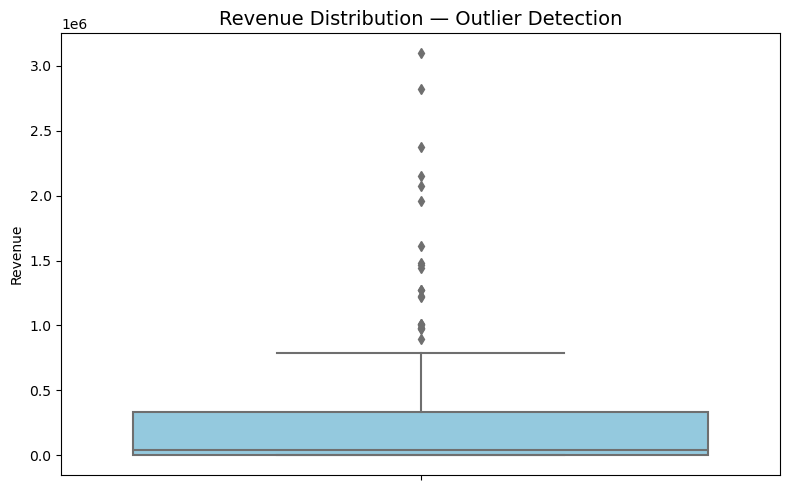

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(y=merged_df['Revenue'], color='skyblue')
plt.title("Revenue Distribution — Outlier Detection", fontsize=14)
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

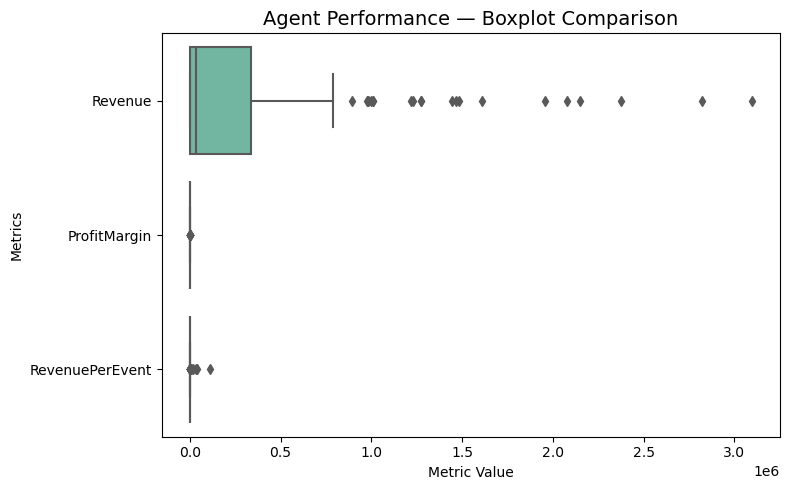

In [10]:
metrics = ['Revenue', 'ProfitMargin', 'RevenuePerEvent']
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df[metrics], orient="h", palette="Set2")
plt.title("Agent Performance — Boxplot Comparison", fontsize=14)
plt.xlabel("Metric Value")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()

In [17]:
merged_df = merged_df[['TotalLeads','TotalBlueCards','Revenue','ProfitMargin','RevenuePerEvent']]


In [19]:
merged_df.to_csv("Cleaned_OperationalMetrics.csv", index=False)
print("✅ Cleaned file exported successfully! Rows:", len(merged_df))

✅ Cleaned file exported successfully! Rows: 174
